In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [ ]:
'''
berdo = pd.merge(berdo2015, berdo2014,
                 how='inner',
                 on=['Address','Property Name'],
                 suffixes=('_2015', '_2014'))
berdo.to_csv(".\\data\\berdo.csv", index=False)
'''

In [2]:
berdo = pd.read_csv(".\\data\\berdo.csv")

print(berdo.columns)

cols_num = ['Gross Area (sq ft)', 'Site EUI (kBTU/sf)',
            'GHG Emissions (MTCO2e)', 'GHG Intensity (kgCO2/sf)',
            ' Total Site Energy (kBTU) ','Water Intensity (gal/sf)'
           ]

cols_percent = ["% Gas", "% Steam", "% Electricity"]

def to_number(s):
    """Converts string s to a float.
    Returns -1 if error"""
    try:
        float(s)
        return float(s)
    except ValueError:
        return -1

def fix_numerical(columns):
    """Tranforms numerical columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            str(x).strip().replace(",","")
                                           )
            berdo[cyear] = berdo[cyear].map(to_number)
            cyear = c
            
def fix_percenteage(columns):
    """Tranforms percentage columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear].fillna("0%", inplace=True)
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            float(x.strip().replace("%",""))
                                           )         
            cyear = c

# transform columsn
fix_numerical(cols_num)
fix_percenteage(cols_percent)

berdo["%_total_2015"] = berdo[["% Gas_2015","% Steam_2015","% Electricity_2015"]].sum(axis=1)
berdo["%_total_2014"] = berdo[["% Gas_2014","% Steam_2014","% Electricity_2014"]].sum(axis=1)

Index(['Property Name', 'Reported_2015', 'Property Type_2015', 'Address',
       'ZIP_2015', 'Gross Area (sq ft)_2015', 'Site EUI (kBTU/sf)_2015',
       'Energy Star Score_2015', 'Energy Star Certified_2015',
       'Property Uses_2015', 'Year Built_2015', 'GHG Emissions (MTCO2e)_2015',
       'GHG Intensity (kgCO2/sf)_2015', ' Total Site Energy (kBTU) _2015',
       '% Electricity_2015', '% Gas_2015', '% Steam_2015',
       'Water Intensity (gal/sf)_2015', 'Onsite Solar (kWh)_2015',
       'User Submitted Info_2015', 'User Submitted Link_2015',
       'Tax Parcel_2015', 'Years Reported', 'Reported_2014',
       'Property Type_2014', 'ZIP_2014', 'Gross Area (sq ft)_2014',
       'Site EUI (kBTU/sf)_2014', 'Energy Star Score_2014',
       'Energy Star Certified_2014', 'Property Uses_2014', 'Year Built_2014',
       'GHG Emissions (MTCO2e)_2014', 'GHG Intensity (kgCO2/sf)_2014',
       ' Total Site Energy (kBTU) _2014', '% Electricity_2014', '% Gas_2014',
       '% Steam_2014', 'Water I

In [3]:
berdo = berdo[["Property Name","Address","ZIP_2015","Year Built_2015",
               "Property Type_2015","Property Type_2014",
               "Gross Area (sq ft)_2015","Gross Area (sq ft)_2014",
               "Site EUI (kBTU/sf)_2015","Site EUI (kBTU/sf)_2014",
               " Total Site Energy (kBTU) _2015"," Total Site Energy (kBTU) _2014",
               "GHG Emissions (MTCO2e)_2015","GHG Emissions (MTCO2e)_2014",
               "GHG Intensity (kgCO2/sf)_2015","GHG Intensity (kgCO2/sf)_2014",
               "% Electricity_2015", "% Gas_2015", "% Steam_2015","%_total_2015",
               "% Electricity_2014", "% Gas_2014", "% Steam_2014","%_total_2014"
              ]]

### remove data that doesn't seem right. A deeper investigation should be done here
#print(berdo.isnull().sum())
print(berdo.shape)

print("---------")

# set values -1 to NaN
berdo.replace(-1,np.NaN,inplace=True)
# remove if total energy < 90. Check these deeper
berdo = berdo[(berdo["%_total_2015"] > 90) & (berdo["%_total_2014"] > 90)]
# drop all missing values
berdo.dropna(axis=0, how='any', inplace=True)
print(berdo.shape)

(1086, 24)
---------
(923, 24)


In [4]:
berdo_diff = pd.DataFrame()
berdo_diff[["property_name", "address","zip","year_built"]] = berdo[["Property Name","Address","ZIP_2015","Year Built_2015"]]
berdo_diff[["property_type_2015","property_type_2014"]] = berdo[["Property Type_2015","Property Type_2014"]]
berdo_diff["gloss_area_sqft"] = berdo["Gross Area (sq ft)_2015"]
berdo_diff["gloss_area_sqft_diff"] = berdo["Gross Area (sq ft)_2015"] - berdo["Gross Area (sq ft)_2014"]
berdo_diff["energy_kbtu/sf_diff"] = berdo["Site EUI (kBTU/sf)_2015"] - berdo["Site EUI (kBTU/sf)_2014"]
berdo_diff["energy_total_kbtu_diff"] = berdo[" Total Site Energy (kBTU) _2015"] - berdo[" Total Site Energy (kBTU) _2014"]
berdo_diff["ghg_emissions_mtco2e_diff"] = berdo["GHG Emissions (MTCO2e)_2015"] - berdo["GHG Emissions (MTCO2e)_2014"]
berdo_diff["ghg_intensity_kgco2/sf_diff"] = berdo["GHG Intensity (kgCO2/sf)_2015"] - berdo["GHG Intensity (kgCO2/sf)_2014"]

In [207]:
import requests

def get_long_lat(address):
  
    fix_add = address.replace(" ","+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' + fix_add + ',+Boston,+Massachusetts,+USA'
    try:        
        response = requests.get(url)
        resp_json_payload = response.json()
        print(resp_json_payload)
        info = (resp_json_payload['results'][0]['geometry']['location'])
    except:
        return "0 0" 
            
    return (str(info['lat'])+" "+str(info['lng']))

berdo_diff["lat_long"] =  berdo_diff.address.map(get_long_lat)

In [208]:
berdo_diff.lat_long.value_counts()

0 0    923
Name: lat_long, dtype: int64

In [ ]:
berdo_diff.lat_long.isnull().sum()

In [ ]:
berdo_diff["lat"] = berdo_diff.lat_long.map(lambda x: float(x.split()[0]))
berdo_diff["long"] = berdo_diff.lat_long.map(lambda x: float(x.split()[1]))

In [44]:
berdo_diff.drop(["lat_long"],inplace=True)
berdo_diff.to_csv("./data/berdo_diff.csv", index=False)

1) Map with highest to lowest diff

2) avg/median diff by property type

3) avg/median diff by property zip code

4) avg/median diff by property decade built


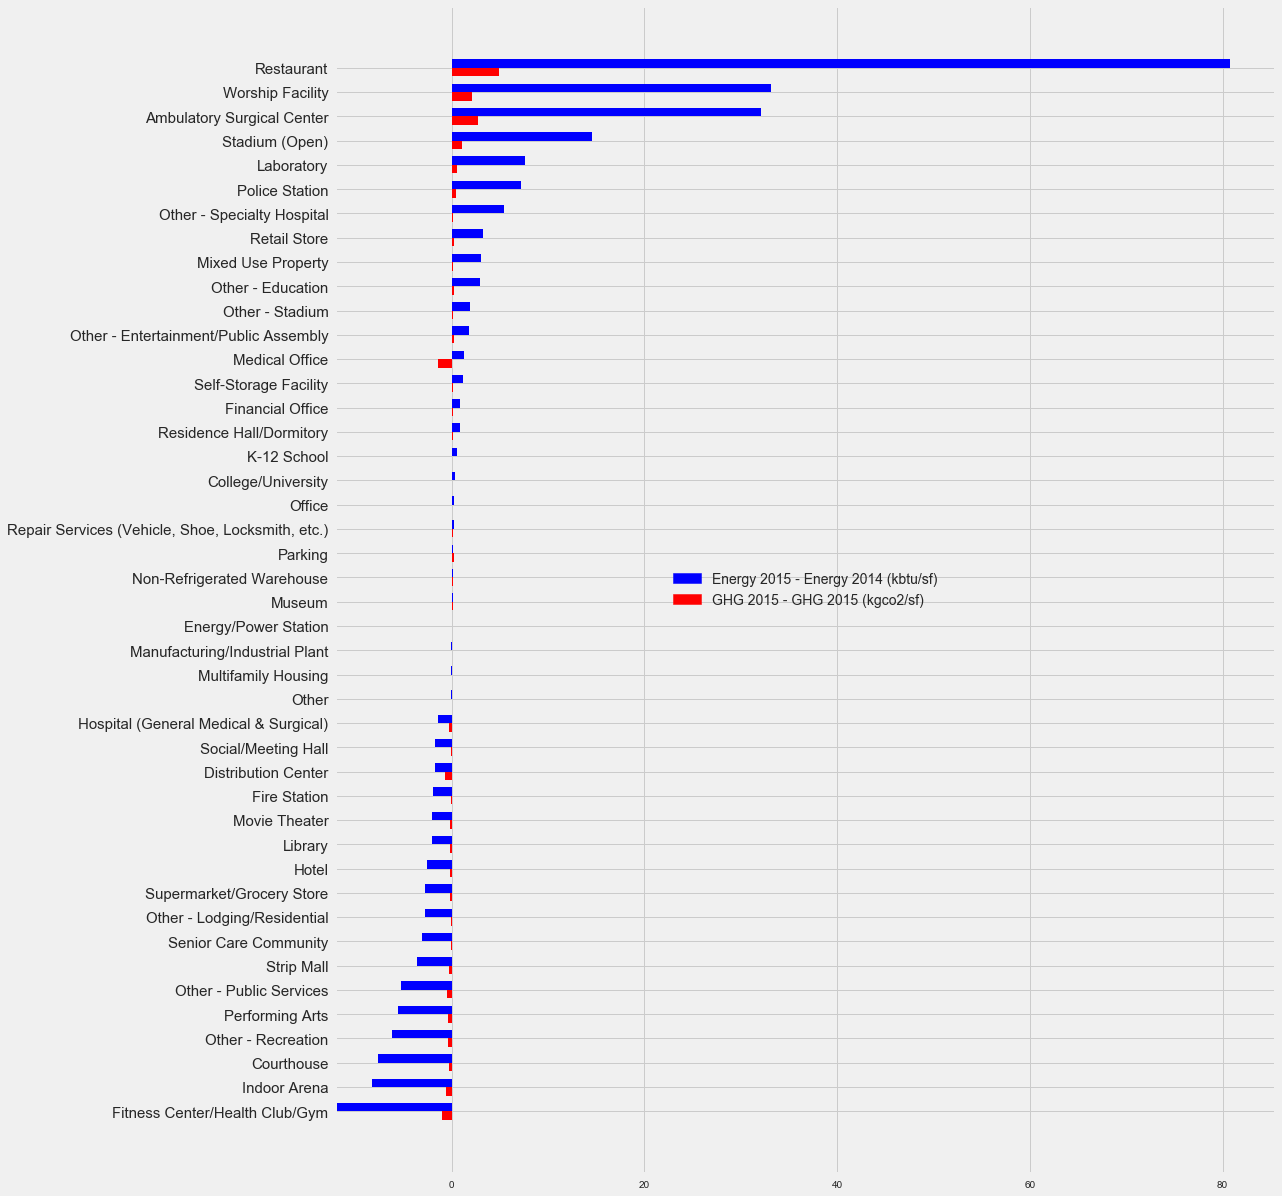

In [176]:
a = berdo_diff.groupby(["property_type_2015"])['energy_kbtu/sf_diff'].median()
a = a[a <1000].sort_values()
b = berdo_diff.groupby(["property_type_2015"])['ghg_intensity_kgco2/sf_diff'].median()
b = b[b <500].sort_values()
c = pd.concat([a, b], axis=1).sort_values("energy_kbtu/sf_diff")

import matplotlib.patches as mpatches
plt.figure(figsize=(15, 20
                   ))
ax=plt.subplot2grid((1,1), (0,0))

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]
ax.barh(bottom=aa, width=c["energy_kbtu/sf_diff"].values, color="b", align="center",height=width)
ax.barh(bottom=bb, width=c["ghg_intensity_kgco2/sf_diff"].values, color="r", align="center",height=width)
ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

blue_patch = mpatches.Patch(color='blue', label='Energy 2015 - Energy 2014 (kbtu/sf)')
red_patch = mpatches.Patch(color='red', label='GHG 2015 - GHG 2015 (kgco2/sf)')

l = plt.legend(handles=[blue_patch,red_patch],loc='center',prop={'size':14})

plt.show()

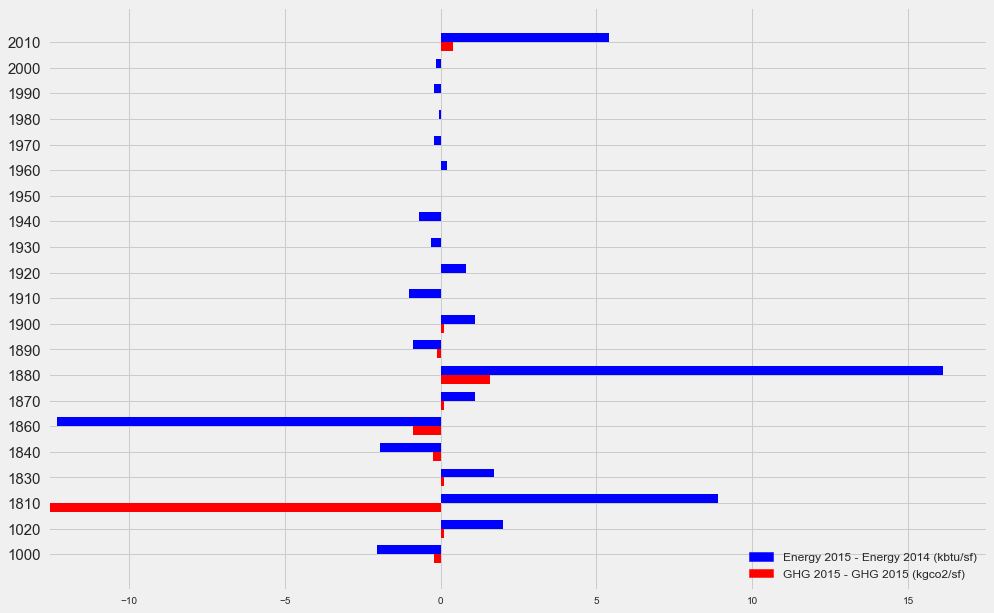

In [206]:
a = berdo_diff.groupby(["decade"])['energy_kbtu/sf_diff'].median()
a = a[a <1000].sort_values()
b = berdo_diff.groupby(["decade"])['ghg_intensity_kgco2/sf_diff'].median()
b = b[b <500].sort_values()
c = pd.concat([a, b], axis=1).sort_index()

import matplotlib.patches as mpatches
plt.figure(figsize=(15, 10))
ax=plt.subplot2grid((1,1), (0,0))

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]
ax.barh(bottom=aa, width=c["energy_kbtu/sf_diff"].values, color="b", align="center",height=width)
ax.barh(bottom=bb, width=c["ghg_intensity_kgco2/sf_diff"].values, color="r", align="center",height=width)
ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

blue_patch = mpatches.Patch(color='blue', label='Energy 2015 - Energy 2014 (kbtu/sf)')
red_patch = mpatches.Patch(color='red', label='GHG 2015 - GHG 2015 (kgco2/sf)')

l = plt.legend(handles=[blue_patch,red_patch],loc='lower right',prop={'size':12})

plt.show()

In [41]:
lat = [-71.0582, -71.0581, -71.0589, -71.0699]
long = [ 42.3600, 42.358, 42.359, 42.3601]

C:\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1775: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


ValueError: shapefile must have lat/lon vertices  - it looks like this one has vertices
in map projection coordinates. You can convert the shapefile to geographic
coordinates using the shpproj utility from the shapelib tools
(http://shapelib.maptools.org/shapelib-tools.html)

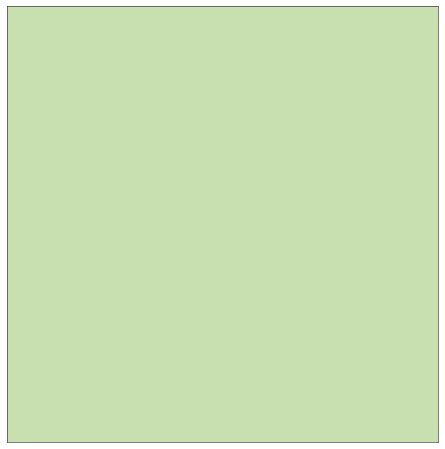

In [43]:
from mpl_toolkits.basemap import Basemap
#import matplotlib.patches as mpatches

west, south, east, north = -71.05, 42.35, -71.06, 42.3601
#low = train_df[train_df["interest_level"] == "low"]
#medium = train_df[train_df["interest_level"] == "medium"]
#high = train_df[train_df["interest_level"] == "high"]

fig = plt.figure(figsize=(17,22))

fig.add_subplot(221)
map = Basemap(llcrnrlat=south, urcrnrlat=north, llcrnrlon=west,
            urcrnrlon=east, lat_ts=south,resolution='i')

map.drawcountries(color="gray")
map.fillcontinents(color='#c8dfb0', lake_color='#53BEFD')
map.drawmapboundary(color='black', linewidth=0.5, fill_color='#53BEFD')
map.readshapefile(name ="Boston", shapefile='./maps/Bos_neighborhoods',drawbounds = False,)

#m.plot(berdo_diff['longitude'].values,berdo_diff['latitude'].values,
map.plot(long,lat,
       'bo', 
       markersize=6,
       color='red',
       alpha=0.8,
       markeredgecolor='yellow',
       markeredgewidth=0.05) 
map.drawmapboundary(fill_color='white')

plt.title("Boston",fontweight = 'bold', size=14)

plt.show()

In [ ]:
fig.add_subplot(222)
m = Basemap(llcrnrlat=south, urcrnrlat=north, llcrnrlon=west,
            urcrnrlon=east, lat_ts=south,resolution='i')

m.plot(low['longitude'].values,low['latitude'].values,
       'bo', 
       markersize=2, color='pink',alpha=0.3,
       markeredgewidth=0.05) 
m.plot(medium['longitude'].values,medium['latitude'].values,
       'bo', 
       markersize=2, color='green',alpha=0.3, 
       markeredgewidth=0.05) 
m.plot(high['longitude'].values,high['latitude'].values,
       'bo', 
       markersize=2, color='blue',alpha=0.3, 
       markeredgewidth=0.05) 
m.drawmapboundary(fill_color='black')

#legend
pink_patch = mpatches.Patch(color='pink', label='low')
green_patch = mpatches.Patch(color='green', label='medium')
blue_patch = mpatches.Patch(color='blue', label='high')
l = plt.legend(handles=[pink_patch,green_patch,blue_patch])
for text in l.get_texts():
    text.set_color("white")



plt.title("NYC Map listings by interest",fontweight = 'bold', size=14)

In [ ]:
self.map = Basemap(projection='merc', lat_0=mlat, lon_0=mlon, resolution = 'l', area_thresh = 1.0, 
llcrnrlon=-num, llcrnrlat=num, 
urcrnrlon=-num, urcrnrlat=num) 

map.readshapefile('/home/person/zipfolder/rds/tl_2010_48_prisecroads', 'Streets',drawbounds = False)

for shape in self.map.Streets:
    xx, yy, = zip(*shape)
    self.map.plot(xx, yy, linewidth = 1.5, color='green', alpha=.75)   
##Same for zip codes

In [ ]:
from pandas.tools.plotting import scatter_matrix

attributes = ["gloss_area_sqft", "energy_kbtu/sf_diff","energy_total_kbtu_diff",
              "ghg_emissions_mtco2e_diff", "ghg_intensity_kgco2/sf_diff"]

scatter_matrix(berdo_diff[attributes], figsize=(25, 20), alpha=1,grid=True)
plt.show()

In [ ]:
set(berdo["Property Type_2015"].value_counts().index.tolist()) - set(berdo["Property Type_2014"].value_counts().index.tolist())

In [ ]:
berdo.shape

In [ ]:
berdo.isnull().sum()

In [ ]:
berdo[["% Gas_2015","% Steam_2015","% Electricity_2015"]].sum(axis=1).value_counts().loc[50:]

In [ ]:
berdo[["% Gas_2014","% Steam_2014","% Electricity_2014"]].sum(axis=1).value_counts()

In [ ]:
berdo["%_total_2015"] = berdo[["% Gas_2015","% Steam_2015","% Electricity_2015"]].sum(axis=1)
berdo["%_total_2014"] = berdo[["% Gas_2014","% Steam_2014","% Electricity_2014"]].sum(axis=1)

In [ ]:
berdo[berdo["Year Built_2015"] != berdo["Year Built_2014"]][["Year Built_2015","Year Built_2014"]]

In [ ]:
berdo[["Property Name","Address","ZIP_2015","Year Built_2015"
       "Property Type_2015","Property Type_2014"
       "Gross Area (sq ft)_2015","Gross Area (sq ft)_2014",
       "Site EUI (kBTU/sf)_2015","Site EUI (kBTU/sf)_2014",
       " Total Site Energy (kBTU) _2015"," Total Site Energy (kBTU) _2014",
       "GHG Emissions (MTCO2e)_2015","GHG Emissions (MTCO2e)_2014",
       "GHG Intensity (kgCO2/sf)_2015","GHG Intensity (kgCO2/sf)_2014"
      ]]